In [6]:
#| default_exp training

In [7]:
#| export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from functools import reduce
from torch import optim


In [8]:
import fastcore.all as fc
import random

In [9]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('../data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
     

In [10]:
n, features = x_train.shape
predictionCategories = y_train.max()+1
nh = 50

lr = 0.2
epochs = 5
bs = 50
predictionCategories

tensor(10)

### Cross entropy loss 

In the case of one hot encoded answer vectors, cross entropy loss is really just `-log(pi)`  where pi is the prediction value of the target.  A softmax must be completed before the loss calculation step.

All this is contained in `F.cross_entropy`

In [11]:
#| export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [12]:
#| export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

> An example of how nn.Module registers added children as parameters

In [13]:
my_list = [1, 2, 3]
reduce(lambda x,y: f'{x}, {y}', my_list, "My Numbers: ")

'My Numbers: , 1, 2, 3'

In [14]:
class MyModule:
    def __init__(self):
        self._modules = {}
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [15]:
myModule = MyModule()
myModule.layer1 = nn.Linear(1, 2)
myModule, list(myModule.parameters())

({'layer1': Linear(in_features=1, out_features=2, bias=True)},
 [Parameter containing:
  tensor([[ 0.52],
          [-0.44]], requires_grad=True),
  Parameter containing:
  tensor([-0.19,  0.47], requires_grad=True)])

> All of the above code is contained in nn.Sequential

In [16]:
class Optimizer(): 
    def __init__(self, params, lr=0.5): 
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
            
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [17]:
model = nn.Sequential(nn.Linear(features, nh), nn.ReLU(), nn.Linear(nh, predictionCategories))
opt = Optimizer(model.parameters())

In [18]:
loss_func = F.cross_entropy

In [19]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.94
0.15, 0.92
0.14, 0.92
0.13, 0.92
0.11, 0.96


> This optimizer is already implemented by optim.SGD which also includes additional features like momentum

In [20]:
def get_model():
    model = nn.Sequential(nn.Linear(features, nh), nn.ReLU(), nn.Linear(nh, predictionCategories))
    optimizer = optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

In [21]:
#| export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [22]:
class IterTest():
    def __init__(self): self.vals = [1, 2, 3, 4]
    def __iter__(self): 
        for v in self.vals: yield f'value: {v}'
        
# class IterTest2():
#     def __init__(self): self.iterTest, self.letters = IterTest(), ['a', 'b', 'c']
#     def __iter__(self): 
#        yield from ( for b in self.iterTest)

In [23]:
testIter = iter(IterTest())
print(next(testIter))
print(next(testIter))
print(list(testIter))



value: 1
value: 2
['value: 3', 'value: 4']


In [24]:
? fc.store_attr


Signature:
 fc.store_attr(
    names=None,
    self=None,
    but='',
    cast=False,
    store_args=None,
    **attrs,
)
Docstring: Store params named in comma-separated `names` from calling context into attrs in `self`
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastcore/basics.py
Type:      function

In [25]:
? fc.chunked

Signature:  fc.chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)
Docstring: Return batches from iterator `it` of size `chunk_sz` (or return `n_chunks` total)
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastcore/basics.py
Type:      function

In [26]:
? random.shuffle

Signature:  random.shuffle(x)
Docstring: Shuffle list x in place, and return None.
File:      ~/miniforge3/envs/fastai/lib/python3.11/random.py
Type:      method

In [27]:
? range

Init signature:  range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [28]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
next(iter(train_ds))

(tensor([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.07,
         0.07

In [29]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if(self.shuffle): random.shuffle(res)
        return iter(res)

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)



class DataLoader():
    def __init__(self, ds, batches, collate_fn=collate):fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches)
    

In [30]:
def badCollate(b): return b

In [31]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)
bad_train_dl = DataLoader(train_ds, train_samp, collate_fn=badCollate)


In [32]:
? zip

Init signature:  zip(self, /, *args, **kwargs)
Docstring:     
zip(*iterables, strict=False) --> Yield tuples until an input is exhausted.

   >>> list(zip('abcdefg', range(3), range(4)))
   [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]

The zip object yields n-length tuples, where n is the number of iterables
passed as positional arguments to zip().  The i-th element in every tuple
comes from the i-th iterable argument to zip().  This continues until the
shortest argument is exhausted.

If strict is true and one of the arguments is exhausted before the others,
raise a ValueError.
Type:           type
Subclasses:     

In [33]:
a = [1,2,3]
print(a)
print(*a)
print(a[0], a[1], a[2])

[1, 2, 3]
1 2 3
1 2 3


In [34]:
x, y = zip(*next(iter(bad_train_dl)))
torch.stack(y)


tensor([2, 8, 7, 2, 1, 3, 8, 6, 7, 8, 4, 1, 6, 1, 9, 4, 0, 9, 6, 2, 9, 3, 5, 9, 3, 0, 6, 1, 7, 5, 1, 8, 9, 1, 1, 5, 7, 4, 6, 4, 4, 0, 0, 4,
        2, 3, 7, 0, 8, 4])

tensor(9)

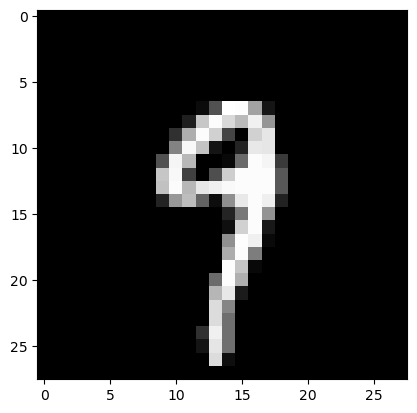

In [35]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [36]:
train_ds[next(iter(train_samp))]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([7, 1, 5, 3, 2, 6, 7, 2, 6, 2, 7, 3, 7, 0, 6, 3, 2, 5, 1, 8, 9, 2, 7, 7, 2, 2, 0, 4, 9, 6, 1, 1, 2, 7, 5, 4, 4, 4, 1, 9, 0, 1, 4, 8,
         8, 9, 7, 2, 5, 0]))

In [37]:
collate(train_ds[i] for i in next(iter(train_samp)))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([8, 9, 8, 4, 6, 4, 6, 0, 7, 8, 1, 7, 8, 9, 7, 5, 6, 4, 4, 9, 4, 7, 5, 9, 7, 6, 0, 1, 4, 4, 0, 7, 8, 6, 1, 6, 0, 4, 5, 8, 9, 5, 1, 2,
         7, 6, 8, 4, 7, 3]))

In [38]:
#| export
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)
        
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
            print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

### Data loader in pytorch

In [39]:
#| export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler


In [40]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

train_dl = DataLoader(train_ds)
valid_dl = DataLoader(valid_ds)

In [41]:
#| export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs))

In [42]:
model, opt = get_model()
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
fit()



0.14, 0.96
0 0.19284493958577514 0.946200003027916
0.31, 0.92
1 0.15838701024651528 0.9539000064134597
0.15, 0.96
2 0.12284666760824621 0.9626000046730041
0.08, 0.94
3 0.10450778256170451 0.968800008893013
0.15, 0.94
4 0.10737767970189452 0.9667000055313111


(0.10737767970189452, 0.9667000055313111)

In [46]:
import nbdev; nbdev.nbdev_export()
